In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
import pylab
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# for ANN   

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
#讀取資料並列出前五筆
df=pd.read_csv("C:/Users/User/Desktop/(Practice) Kaggle/(Practice) Bank Customer Churn Prediction/Churn_Modelling.csv")
print(df.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

In [4]:
#把不具有意義、可能會模型成效的欄刪除
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)

In [5]:
#查看df中各欄位的資料筆數、是否有缺失值、Data type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [6]:
#敘述性統計
df.describe().T #探討coefficient of variation(cv)

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


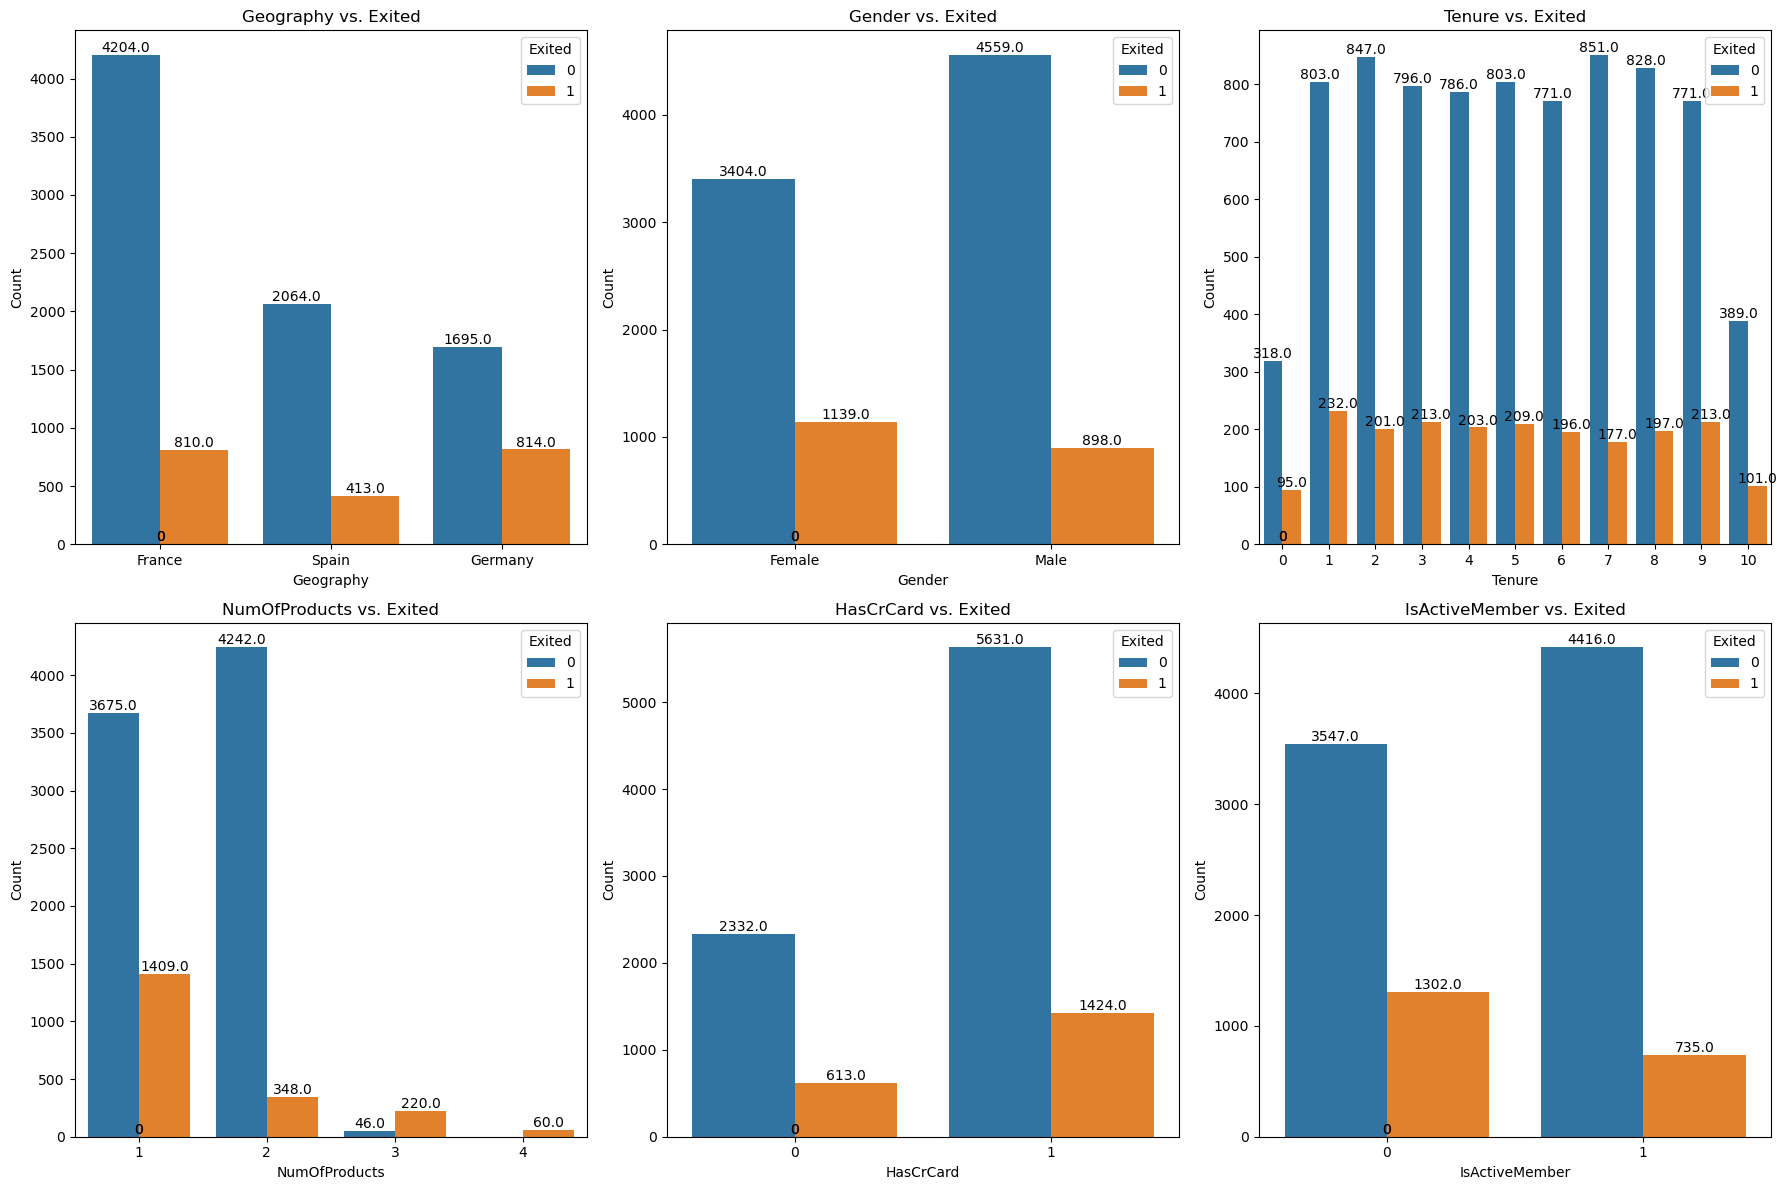

In [7]:
features = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

for ax, feature in zip(axs.flatten(), features):
    sns.countplot(x=feature, hue='Exited', data=df, ax=ax)
    ax.set_title(f'{feature} vs. Exited')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')

    # Add values on the bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.tight_layout()
plt.show()

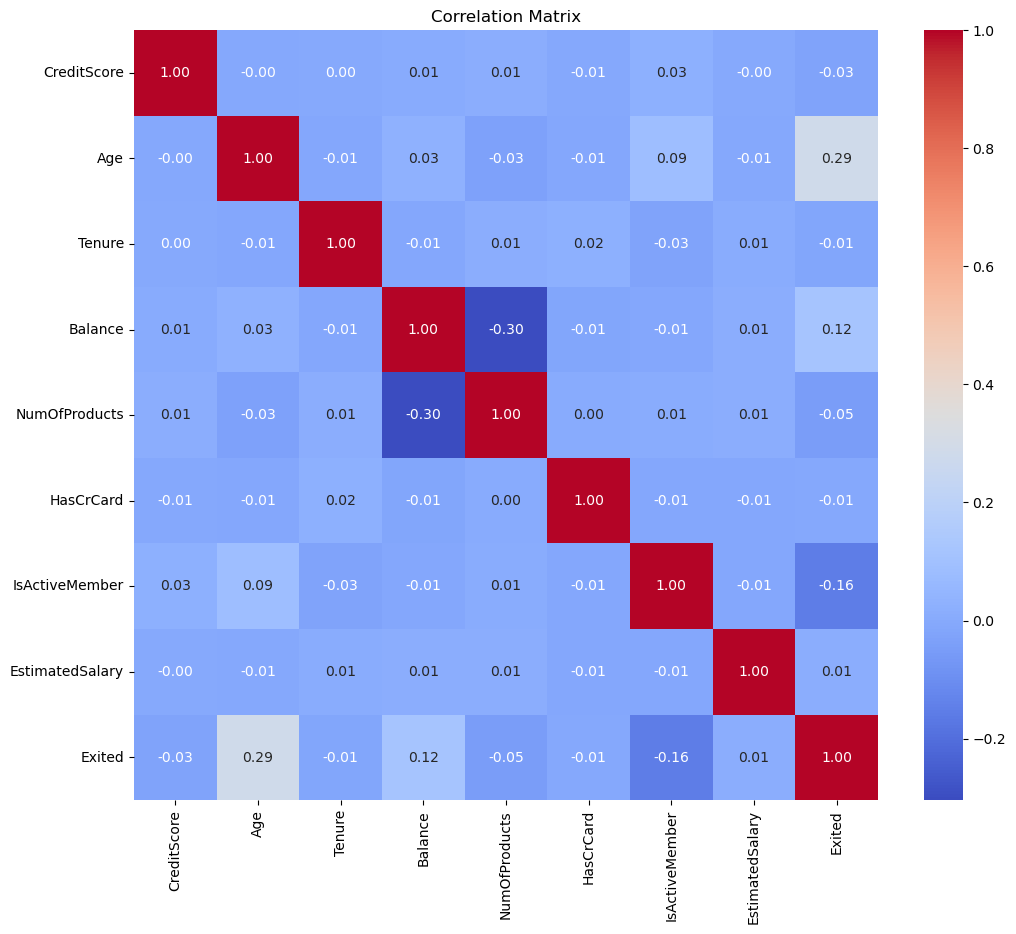

In [8]:
# create correlation plot
plt.figure(figsize=(12, 10))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

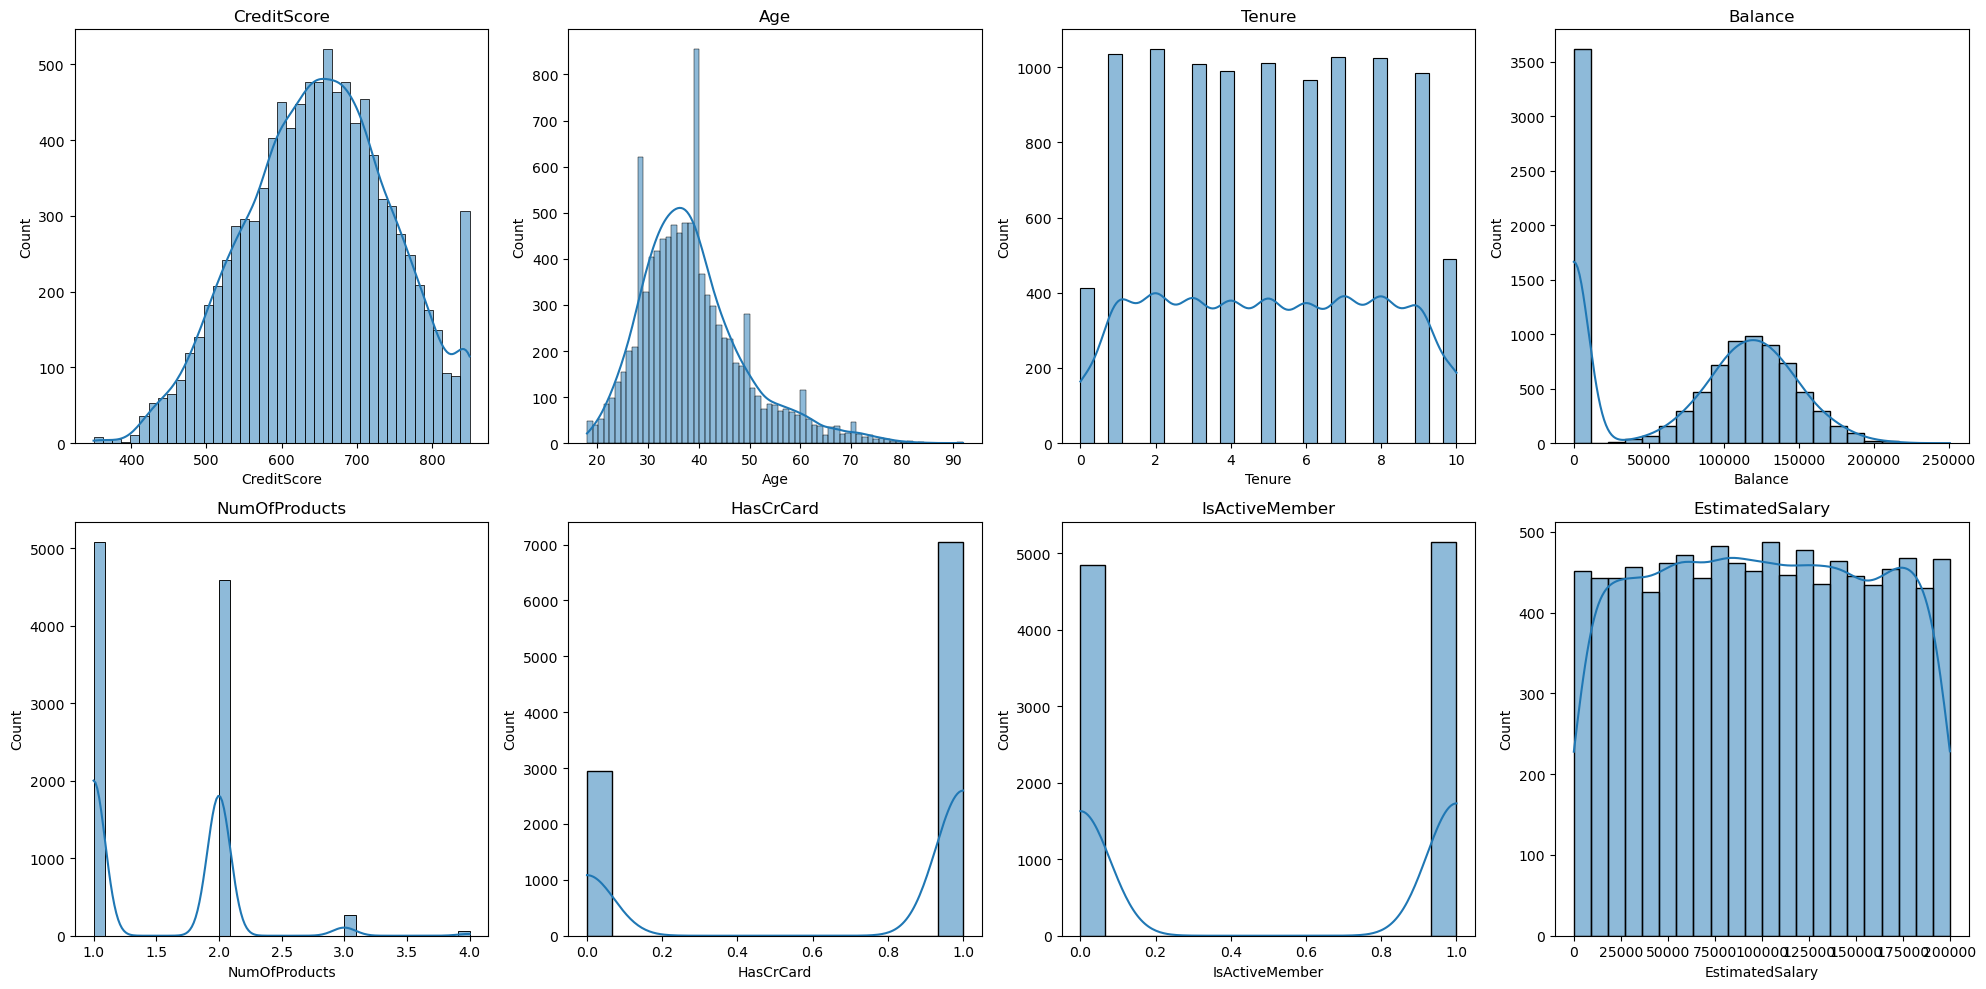

In [9]:
# Create histograms
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

# List of variables
variables = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

for ax, var in zip(axes.flatten(), variables):
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_title(var)

plt.tight_layout()
plt.show()

In [10]:
# print skewnss 
print(df.select_dtypes(include=['number']).skew())
print("Skewness before transformation:")
print(df['Age'].skew())

# Apply logarithmic transformation (base 10) to the 'Age' variable
# Adding a small constant (1e-9) to avoid log(0) if there are any zero values
df['Age'] = np.log10(df['Age'] + 1e-9)

print("Skewness after transformation:")
print(df['Age'].skew())

CreditScore       -0.071607
Age                1.011320
Tenure             0.010991
Balance           -0.141109
NumOfProducts      0.745568
HasCrCard         -0.901812
IsActiveMember    -0.060437
EstimatedSalary    0.002085
Exited             1.471611
dtype: float64
Skewness before transformation:
1.0113202630234552
Skewness after transformation:
0.18202011258158898


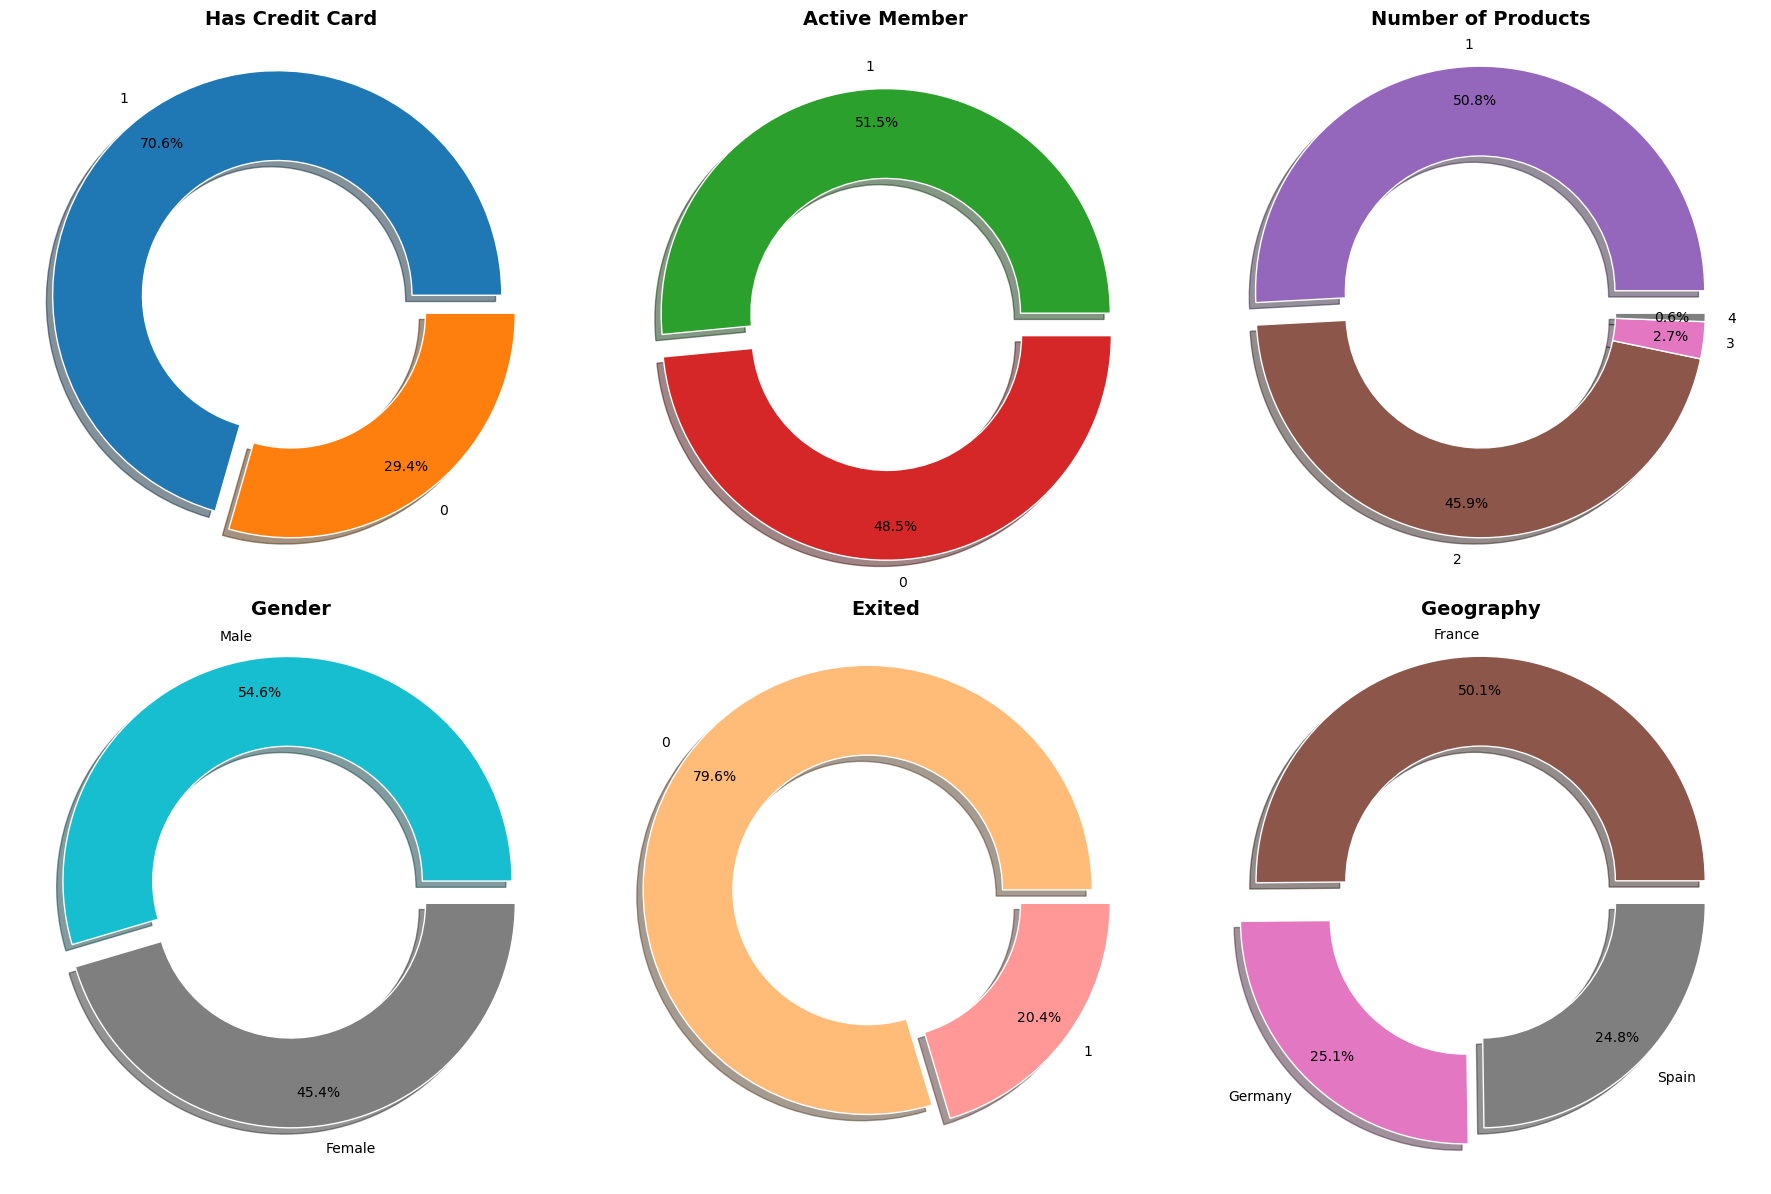

In [11]:
# Define colors and explode values for each pie chart
colors = {
    'HasCrCard': ['#1f77b4', '#ff7f0e'],
    'IsActiveMember': ['#2ca02c', '#d62728'],
    'NumOfProducts': ['#9467bd', '#8c564b', '#e377c2', '#7f7f7f'],
    'Gender': ['#17becf', '#7f7f7f'],
    'Exited': ['#ffbb78', '#ff9896'],
    'Geography': ['#8c564b', '#e377c2', '#7f7f7f']
}

explode_values = {
    'HasCrCard': (0.1, 0),
    'IsActiveMember': (0, 0.1),
    'NumOfProducts': (0.1, 0, 0, 0),
    'Gender': (0.1, 0),
    'Exited': (0.1, 0),
    'Geography': (0.1, 0.1, 0)
}

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# List of columns and titles
columns = ['HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Gender', 'Exited', 'Geography']
titles = ['Has Credit Card', 'Active Member', 'Number of Products', 'Gender', 'Exited', 'Geography']

# Plot each pie chart
for ax, column, title in zip(axs.flatten(), columns, titles):
    counts = df[column].value_counts()
    ax.pie(
        counts,
        labels=counts.index,
        autopct='%1.1f%%',
        colors=colors[column],
        explode=explode_values[column] + (0,) * (len(counts) - len(explode_values[column])),
        shadow=True,
        wedgeprops=dict(width=0.4, edgecolor='w'),
        pctdistance=0.85
    )
    ax.set_title(title, fontsize=14, fontweight='bold')

# Adjust layout
plt.tight_layout()
plt.show()

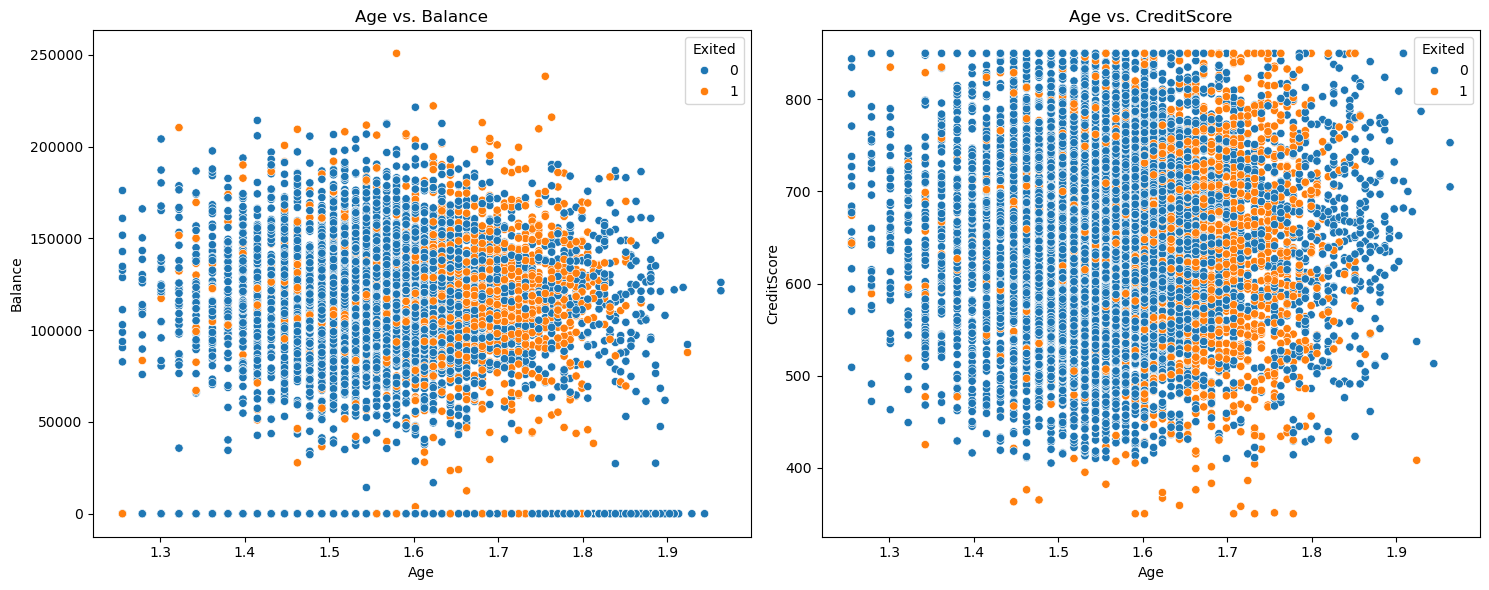

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(x='Age', y='Balance', hue='Exited', data=df, ax=axs[0])
sns.scatterplot(x='Age', y='CreditScore', hue='Exited', data=df, ax=axs[1])

axs[0].set_title('Age vs. Balance')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Balance')
axs[1].set_title('Age vs. CreditScore')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('CreditScore')

plt.tight_layout()
plt.show()

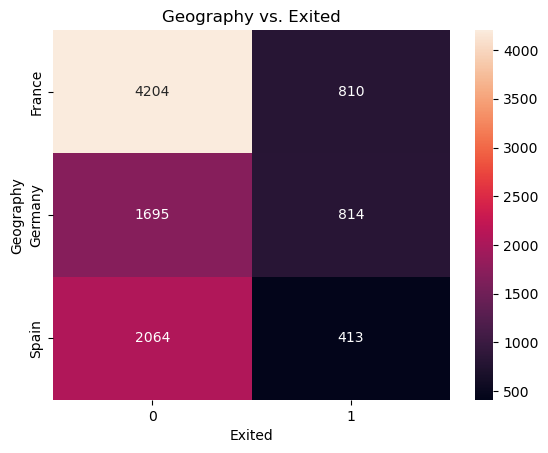

In [13]:
# create cross table
table = pd.crosstab(df['Geography'], df['Exited'])
sns.heatmap(table, annot=True,  fmt='g')
plt.title('Geography vs. Exited')
plt.show()

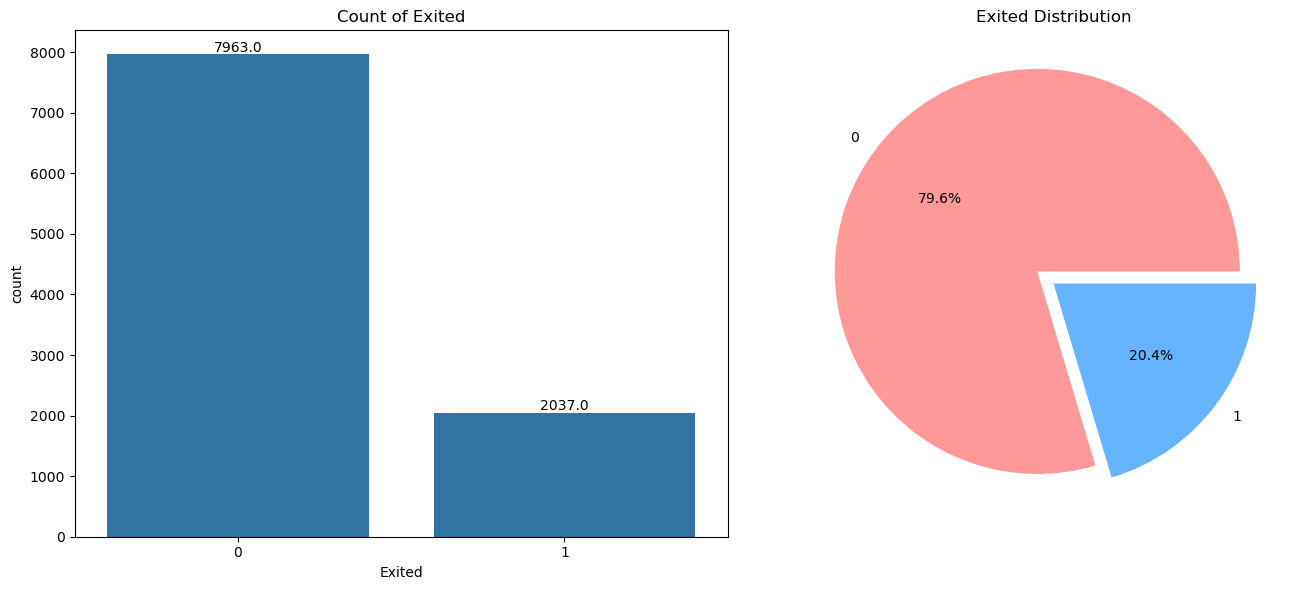

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Count plot with values on bars
sns.countplot(x='Exited', data=df, ax=axs[0])
axs[0].set_title('Count of Exited')
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Pie chart
exit_counts = df['Exited'].value_counts()
axs[1].pie(exit_counts, labels=exit_counts.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], explode=(0.1, 0))
axs[1].set_title('Exited Distribution')
plt.tight_layout()
plt.show()

In [15]:
df_majority = df[df['Exited'] == 0]
df_minority = df[df['Exited'] == 1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,  # Sample with replacement
                                 n_samples=len(df_majority),  # Match the majority class
                                 random_state=42)  # For reproducibility

# Combine the majority class with the upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Shuffle the dataset
df= df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

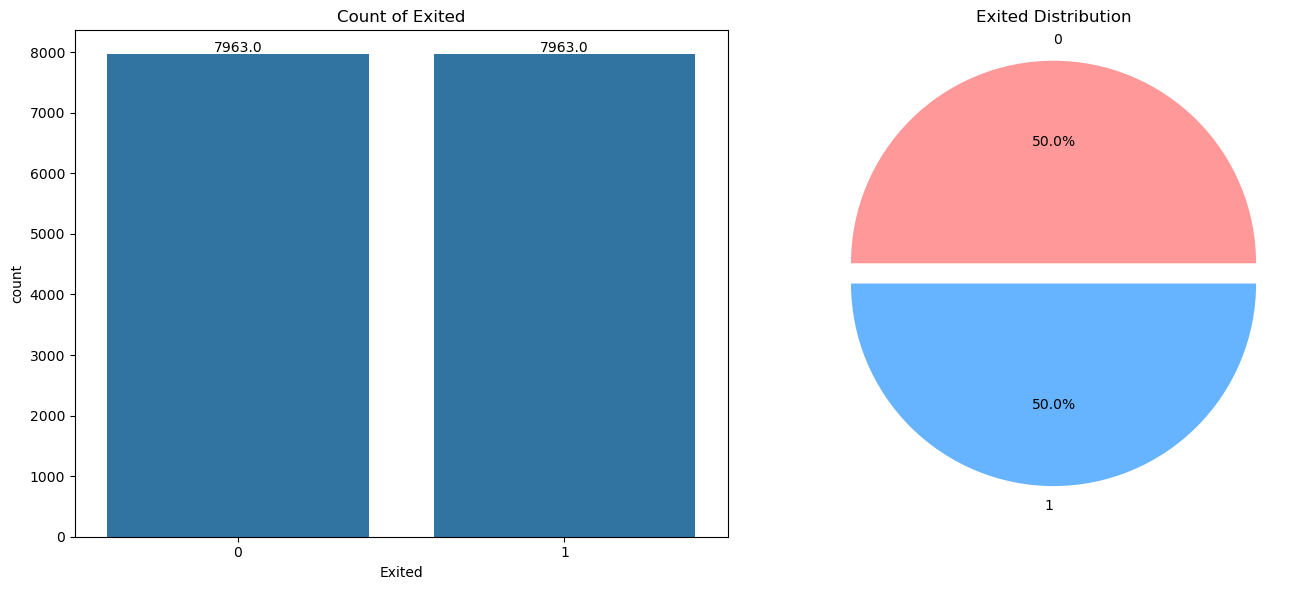

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Count plot with values on bars
sns.countplot(x='Exited', data=df, ax=axs[0])
axs[0].set_title('Count of Exited')
for p in axs[0].patches:
    height = p.get_height()
    axs[0].annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Pie chart
exit_counts = df['Exited'].value_counts()
axs[1].pie(exit_counts, labels=exit_counts.index, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], explode=(0.1, 0))
axs[1].set_title('Exited Distribution')

plt.tight_layout()
plt.show()

In [17]:
# onehot on Geography column
df = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)

In [18]:
df.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,692,1.662758,2,0.00,2,1,1,105983.09,0,False,True,True
1,516,1.568202,8,113143.12,1,0,0,3363.36,0,False,False,False
2,531,1.568202,1,143407.29,2,0,1,84402.46,0,False,True,True
3,717,1.556303,2,99472.76,2,1,0,94274.72,1,False,False,False
4,737,1.633468,1,125537.38,1,1,0,138510.01,1,True,False,False


In [19]:
# let's split data
X = df.drop(columns=['Exited'])
y = df['Exited']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [20]:
from sklearn.preprocessing import StandardScaler
# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [21]:
# Build the model
model = Sequential()
    
    # Input layer + First hidden layer
model.add(Dense(units=352, activation='tanh', input_dim = 11))
model.add(Dropout(0.2))

# Additional hidden layers based on best hyperparameters
model.add(Dense(units=160, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.01))
model.add(Dense(units=384, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.01))
model.add(Dense(units=448, activation='tanh'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(units=352, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.34))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.0))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.0))
model.add(Dense(units=32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.0))

    # Output layer
model.add(Dense(units=1, activation='sigmoid'))  # Change to 'softmax' for multi-class classification

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',  # Change to 'categorical_crossentropy' for multi-class
                  metrics=['accuracy'])

In [23]:
# define early stopping
early_stopping = EarlyStopping( patience=5, restore_best_weights=True)
# Train model
history = model.fit(X_train, y_train,epochs=500,
 validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6699 - loss: 0.6264 - val_accuracy: 0.7470 - val_loss: 0.5144
Epoch 2/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7536 - loss: 0.5097 - val_accuracy: 0.7596 - val_loss: 0.4764
Epoch 3/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7609 - loss: 0.4936 - val_accuracy: 0.7721 - val_loss: 0.4650
Epoch 4/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7607 - loss: 0.4912 - val_accuracy: 0.7728 - val_loss: 0.4637
Epoch 5/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7672 - loss: 0.4820 - val_accuracy: 0.7778 - val_loss: 0.4600
Epoch 6/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7685 - loss: 0.4796 - val_accuracy: 0.7815 - val_loss: 0.4601
Epoch 7/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7667 - loss: 0.4749 - val_accuracy: 0.7828 - val_loss: 0.4598
Epoch 8/500
399/399 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7653 - loss: 0.4764 - val_accu

In [24]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7788 - loss: 0.4479
Test accuracy: 0.778719425201416


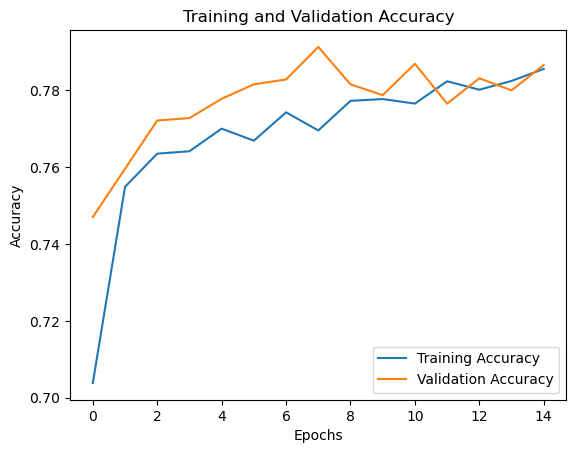

In [25]:
# Plot training accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
# Plot validation accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
# Add legend to the plot
plt.legend()
# Show the plot
plt.show()

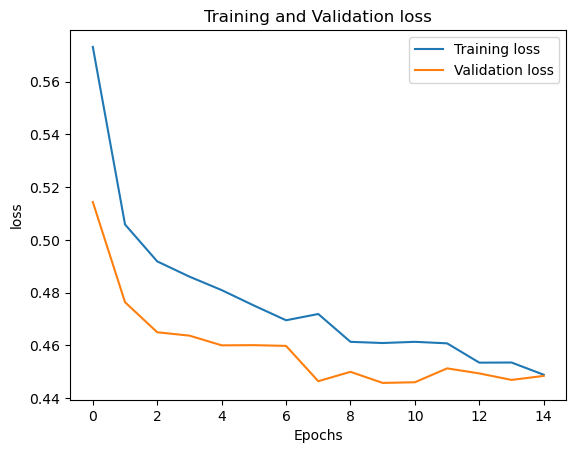

In [26]:
# Plot training accuracy
plt.plot(history.history['loss'], label='Training loss')
# Plot validation accuracy
plt.plot(history.history['val_loss'], label='Validation loss')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Training and Validation loss')
# Add legend to the plot
plt.legend()
# Show the plot
plt.show()

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.78      0.78      1582
           1       0.78      0.78      0.78      1604

    accuracy                           0.78      3186
   macro avg       0.78      0.78      0.78      3186
weighted avg       0.78      0.78      0.78      3186



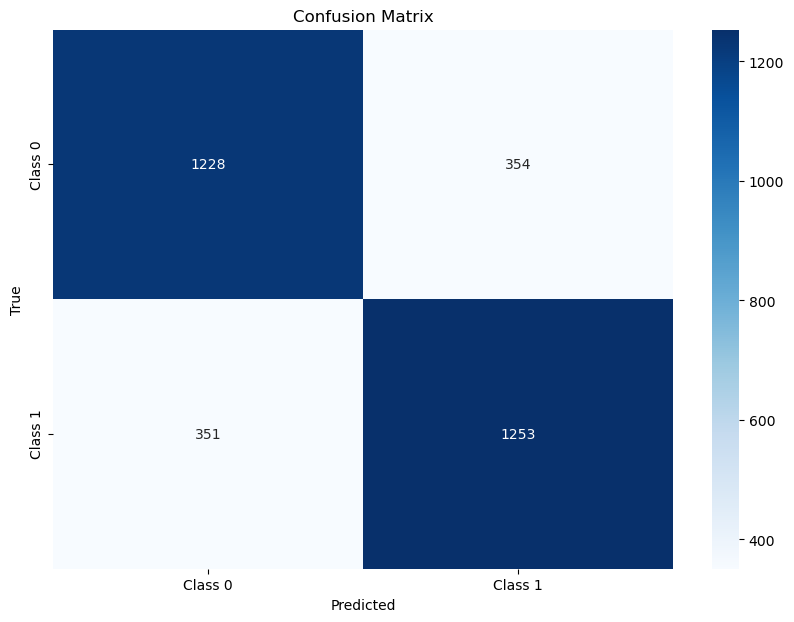

In [27]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary class labels

# Print classification report
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()